# Benchmarking Simpson's variance estimators on simulated data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import random
import matplotlib.ticker as ticker

from pydiver import *
import pyrepseq.plotting as pp

plt.style.use('estimator.mplstyle')

## Communities with Dirichlet distributed relative species abundances

In [2]:
paramss = [(4.0, 1000),
           (1.0, 1000),
           (0.25, 1000),
          ]
sample_sizes = list(sorted(pd.unique([int(v) for v in np.logspace(np.log10(10), 4, 20)])))
nrepetitions = 1000


estimators = ['chao', 'plugin', 'grundmann', 'unbiased', 'poisson']
nbootstrap_chao = 200

Ps = {}
for params in paramss:
    alpha, k  = params
    P = np.random.dirichlet(alpha*np.ones(k))
    Ps[params] = P

data = []
for (alpha, k), P in Ps.items():
    for sample_size in sample_sizes:
        theory = varpc_population(P, sample_size)
        results = {estimator: [] for estimator in estimators}
        for i in range(nrepetitions):
            sample_p = np.random.choice(np.arange(len(P)), p=P, replace=True, size=sample_size)
            for estimator in estimators:
                estimate = varpc_sample(sample_p, method=estimator,
                                bootnum=nbootstrap_chao,
                                poisson_bound=False)
                results[estimator].append(estimate)
        
        for estimator in estimators:
            values = results[estimator]
            variance = np.var(values)
            bias = np.mean(values)-theory
            data.append([alpha, k, estimator, sample_size, bias, variance, theory])
results_columns = ['alpha', 'k', 'estimator', 'N', 'bias', 'variance', 'theory']
df = pd.DataFrame(data=data, columns=results_columns)
df['hatvarvar_norm'] = df['variance']/df['theory']**2
df['hatvarbias_fraction'] = df['bias']/df['theory']
df['logN'] = np.log10(df['N'])

In [3]:
estimator_to_label = {
    'poisson' : 'Poisson',
    'chao' : 'Chao',
    'plugin' :  'Plugin',
    'grundmann' : 'Grundmann',
    'unbiased' : 'Unbiased',
    'bound' : 'Poisson-bound',
    }

In [4]:
def plot_dirichlet(axes, alpha, k, estimators):
    P = Ps[alpha, k]
    
    pp.rankfrequency(P, ax=axes[0], transform_x=np.log10, transform_y=np.log10, log_x=False, log_y=False)
    axes[0].set_xlabel('$log_{10}$ Frequency')
    axes[0].set_ylabel('$log_{10}$ Rank')    
    axes[0].text(1, 1, 'Dirichlet:\n'+r'$\alpha$={}'.format(alpha)+'\n'+r'S={}'.format(k),
                 va='top', ha='right',
                 transform=axes[0].transAxes)

    axes[1].axhline(0.0, c='k')
    for ax in axes[1:]:
        Nma = (2*k)**.5
        ax.axvspan(np.log10(min(sample_sizes)), np.log10(Nma), alpha=.2, color='C0')
        ax.axvspan(np.log10(Nma), np.log10(k), alpha=.2, color='C1')
        ax.axvspan(np.log10(k), np.log10(max(sample_sizes)), alpha=.2, color='C2')
    for i, estimator in enumerate(estimators):
        mask = (df['k']==k) & (df['alpha']==alpha) & (df['estimator']==estimator)
        df[mask].plot(x='logN',
                    y='hatvarvar_norm',
                    kind='line',
                    logx=False,
                    logy=False,
                    ax=axes[2],
                    lw=2 if estimator=='unbiased' else 1,
                    c='C'+str(i),
                    label=estimator_to_label[estimator])
        df[mask].plot(x='logN',
                    y='hatvarbias_fraction',
                    kind='line',
                    logx=False,
                    ax=axes[1],
                    lw=2 if estimator=='unbiased' else 1,
                    c='C'+str(i),
                    label=estimator_to_label[estimator])
    axes[2].set_ylabel('Variance')
    axes[1].set_ylabel('Bias')
    for ax in axes[1:]:
        ax.set_xlabel('$\log_{10}$ Sample Size')
        ax.set_xlim(np.log10(min(sample_sizes)), np.log10(max(sample_sizes)))
    axes[1].set_ylim(-1, 1.0)
    axes[2].set_ylim(0.0, 2.0)
    axes[1].legend(frameon=True, ncol=1, loc='lower center', fontsize='medium')
    axes[2].get_legend().remove()

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


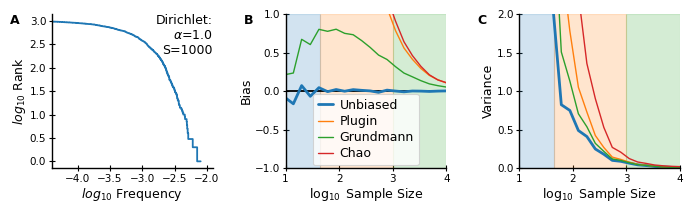

In [5]:
estimators = ['unbiased', 
               'plugin',
               'grundmann',
               'chao',]

fig, axes = plt.subplots(figsize=(7.0, 2.2), ncols=3, nrows=1, sharex=False)
k, alpha = 1000, 1.0
plot_dirichlet(axes, alpha, k, estimators)
axes[0].set_xlim(np.log10(4e-5))

pp.label_axes(fig, xy=(-0.26, 1.0))
fig.tight_layout()
fig.savefig('svgs/fig2.svg')

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),
/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


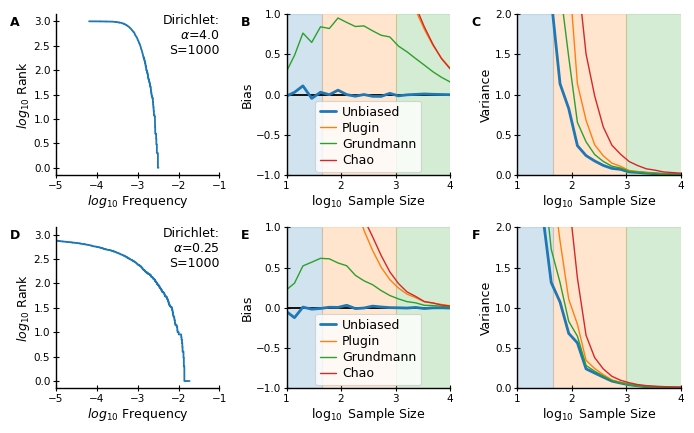

In [6]:
estimators = ['unbiased', 
               'plugin',
               'grundmann',
               'chao']

fig, axes_arr = plt.subplots(figsize=(7.0, 2.2*2), ncols=3, nrows=2, sharex=False)
for i, (alpha, k) in enumerate((paramss[0], paramss[2])):
    axes = axes_arr[i, :]
    plot_dirichlet(axes, alpha, k, estimators)

for ax in axes_arr[:, 0]:
    ax.set_xlim(np.log10(1e-5), np.log10(1e-1))
    
pp.label_axes(fig, xy=(-0.28, 0.99))
fig.tight_layout()
fig.savefig('svgs/figS1.svg')

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


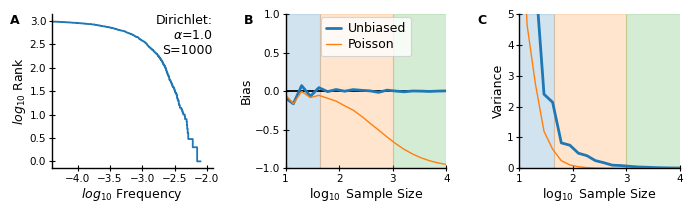

In [7]:
estimators = ['unbiased',
              'poisson']

fig, axes = plt.subplots(figsize=(7.0, 2.2), ncols=3, nrows=1, sharex=False)
k, alpha = 1000, 1.0
plot_dirichlet(axes, alpha, k, estimators)

axes[1].legend(frameon=True, ncol=1, loc='upper center', fontsize='medium')
axes[2].set_ylim(0.0, 5.0)
axes[0].set_xlim(np.log10(4e-5))


pp.label_axes(fig, xy=(-0.26, 1.0))
fig.tight_layout()
fig.savefig('svgs/figS4.svg')

## Communities with heavy-tailed species abundance distributions

In [8]:
k = 1000

estimators = ['unbiased', 
              'plugin',
              'grundmann',
              'chao']

results_columns = ['name', 'k', 'estimator', 'N', 'bias', 'variance', 'theory']
results = []

Pzipf = 1/np.arange(1, k+1)
Pzipf /= np.sum(Pzipf)

Plognormal = np.random.lognormal(0.0, 1.0, k)
Plognormal /= np.sum(Plognormal)

Ps_other = {'zipf' : Pzipf,
            'lognormal' : Plognormal}
data = []
for name, P in Ps_other.items():
    for sample_size in sample_sizes:
        theory = varpc_population(P, sample_size)
        results = {estimator: [] for estimator in estimators}
        for i in range(nrepetitions):
            sample_p = np.random.choice(np.arange(len(P)), p=P, replace=True, size=sample_size)
            for estimator in estimators:
                estimate = varpc_sample(sample_p, method=estimator,
                                bootnum=nbootstrap_chao,
                                poisson_bound=False)
                results[estimator].append(estimate)
        
        for estimator in estimators:
            values = results[estimator]
            variance = np.var(values)
            bias = np.mean(values)-theory
            data.append([name, k, estimator, sample_size, bias, variance, theory])
df = pd.DataFrame(data=data, columns=results_columns)
df['hatvarvar_norm'] = df['variance']/df['theory']**2
df['hatvarbias_fraction'] = df['bias']/df['theory']
df['logN'] = np.log10(df['N'])

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


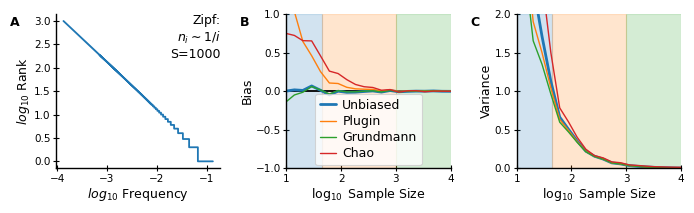

In [9]:
fig, axes = plt.subplots(figsize=(7.0, 2.2), ncols=3, nrows=1, sharex=False)

P = Pzipf
name = 'zipf'

pp.rankfrequency(P, ax=axes[0], transform_x=np.log10, transform_y=np.log10, log_x=False, log_y=False)
axes[0].set_xlabel('$log_{10}$ Frequency')
axes[0].set_ylabel('$log_{10}$ Rank')    
axes[0].text(1, 1, 'Zipf:\n'+r'$n_i \sim 1/i$'+'\n'+rf'S={k}',
             va='top', ha='right',
             transform=axes[0].transAxes)

axes[1].axhline(0.0, c='k')
for ax in axes[1:]:
    Nma = (2*k)**.5
    ax.axvspan(np.log10(min(sample_sizes)), np.log10(Nma), alpha=.2, color='C0')
    ax.axvspan(np.log10(Nma), np.log10(k), alpha=.2, color='C1')
    ax.axvspan(np.log10(k), np.log10(max(sample_sizes)), alpha=.2, color='C2')
for i, estimator in enumerate(estimators):
    mask = (df['estimator'] == estimator) & (df['name'] == name)
    df[mask].plot(x='logN',
                        y='hatvarvar_norm',
                        kind='line',
                        logx=False,
                        logy=False,
                        ax=axes[2],
                        lw=2 if estimator=='unbiased' else 1,
                        c='C'+str(i),
                        label=estimator_to_label[estimator])
    df[mask].plot(x='logN',
                        y='hatvarbias_fraction',
                        kind='line',
                        logx=False,
                        ax=axes[1],
                        lw=2 if estimator=='unbiased' else 1,
                        c='C'+str(i),
                        label=estimator_to_label[estimator])
axes[2].set_ylabel('Variance')
axes[1].set_ylabel('Bias')
for ax in axes[1:]:
    ax.set_xlabel('$\log_{10}$ Sample Size')
    ax.set_xlim(np.log10(min(sample_sizes)), np.log10(max(sample_sizes)))
axes[1].set_ylim(-1, 1.0)
axes[2].set_ylim(0.0, 2.0)
axes[1].legend(frameon=True, ncol=1, loc='lower center', fontsize='medium')
axes[2].get_legend().remove()


pp.label_axes(fig, xy=(-0.28, 0.99))
fig.tight_layout()
fig.savefig('svgs/figS3.svg')

/home/andreas/mambaforge/lib/python3.10/site-packages/pyrepseq/plotting.py:71: RuntimeWarning: divide by zero encountered in log10
  transform_y(scaley * np.arange(sorted_data.size) / norm),


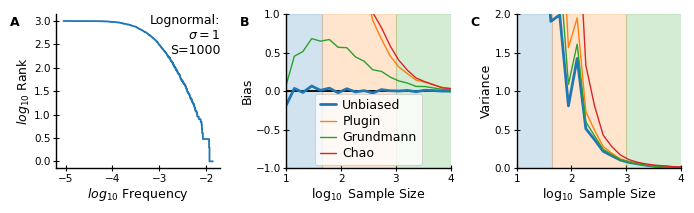

In [10]:
fig, axes = plt.subplots(figsize=(7.0, 2.2), ncols=3, nrows=1, sharex=False)

P = Plognormal
name = 'lognormal'

pp.rankfrequency(P, ax=axes[0], transform_x=np.log10, transform_y=np.log10, log_x=False, log_y=False)
axes[0].set_xlabel('$log_{10}$ Frequency')
axes[0].set_ylabel('$log_{10}$ Rank')    
axes[0].text(1, 1, 'Lognormal:\n'+r'$\sigma = 1$'+'\n'+rf'S={k}',
             va='top', ha='right',
             transform=axes[0].transAxes)

axes[1].axhline(0.0, c='k')
for ax in axes[1:]:
    Nma = (2*k)**.5
    ax.axvspan(np.log10(min(sample_sizes)), np.log10(Nma), alpha=.2, color='C0')
    ax.axvspan(np.log10(Nma), np.log10(k), alpha=.2, color='C1')
    ax.axvspan(np.log10(k), np.log10(max(sample_sizes)), alpha=.2, color='C2')
for i, estimator in enumerate(estimators):
    mask = (df['estimator'] == estimator) & (df['name'] == name)
    df[mask].plot(x='logN',
                    y='hatvarvar_norm',
                    kind='line',
                    logx=False,
                    logy=False,
                    ax=axes[2],
                    lw=2 if estimator=='unbiased' else 1,
                    c='C'+str(i),
                    label=estimator_to_label[estimator])
    df[mask].plot(x='logN',
                    y='hatvarbias_fraction',
                    kind='line',
                    logx=False,
                    ax=axes[1],
                    lw=2 if estimator=='unbiased' else 1,
                    c='C'+str(i),
                    label=estimator_to_label[estimator])
axes[2].set_ylabel('Variance')
axes[1].set_ylabel('Bias')
for ax in axes[1:]:
    ax.set_xlabel('$\log_{10}$ Sample Size')
    ax.set_xlim(np.log10(min(sample_sizes)), np.log10(max(sample_sizes)))
axes[1].set_ylim(-1, 1.0)
axes[2].set_ylim(0.0, 2.0)
axes[1].legend(frameon=True, ncol=1, loc='lower center', fontsize='medium')
axes[2].get_legend().remove()

pp.label_axes(fig, xy=(-0.28, 0.99))
fig.tight_layout()
fig.savefig('svgs/figS2.svg')